# Joint Intent Classification and Slot Filling with Transformers

The goal of this notebook is to fine-tune a pretrained transformer-based neural network model to convert a user query expressed in English into
a representation that is structured enough to be processed by an automated service.

Here is an example of interpretation computed by such a Natural Language Understanding system:

```python
>>> nlu("Book a table for two at Le Ritz for Friday night",
        tokenizer, joint_model, intent_names, slot_names)
```
```
{
    'intent': 'BookRestaurant',
    'slots': {
        'party_size_number': 'two',
        'restaurant_name': 'Le Ritz',
        'timeRange': 'Friday night'
    }
}
```

Intent classification is a simple sequence classification problem. The trick is to treat the structured knowledge extraction part ("Slot Filling") as token-level classification problem using BIO-annotations:

```python
>>> show_predictions("Book a table for two at Le Ritz for Friday night!",
...                  tokenizer, joint_model, intent_names, slot_names)
```
```
## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O
```

We will show how to train a such as join "sequence classification" and "token classification" joint model on a [voice command dataset]() published by snips.ai.


This notebook is a partial reproduction of some of the results presented in this paper:

BERT for Joint Intent Classification and Slot Filling
Qian Chen, Zhu Zhuo, Wen Wang

https://arxiv.org/abs/1902.10909

In [253]:
#%tensorflow_version 2.x

In [254]:
#!nvidia-smi

In [255]:
#%pip install -q transformers

## The Data

We will use a speech command dataset collected, annotated and published by French startup SNIPS.ai (bought in 2019 by Audio device manufacturer Sonos).

The original dataset comes in [YAML format with inline markdown annotations](https://snips-nlu.readthedocs.io/en/latest/dataset.html).

Instead we will use a preprocessed variant with token level B-I-O annotations closer the representation our model will predict. This variant of the SNIPS
dataset was prepared by [Su Zhu](https://github.com/sz128).



In [256]:
from urllib.request import urlretrieve
from pathlib import Path


# SNIPS_DATA_BASE_URL = (
#     "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
#     "master/data/snips/"
# )
for filename in ["train", "valid", "test", "vocab.intent", "vocab.slot"]:
    path = Path(filename)
    if not path.exists():
        print(f"Downloading {filename}...")
        urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

Let's have a look at the first lines from the training set:

In [257]:
lines_train = Path("train").read_text("utf-8").strip().splitlines()
lines_train[:5]

['varanasi:B-location_name roadways:B-roadways <=> ShowPlaceRoadways',
 'varanasi:B-location_name history:B-history <=> ShowPlaceHistory',
 'varanasi:B-location_name ghat:B-ghat <=> ShowPlaceRiverGhats',
 'varanasi:B-location_name Foodies:B-people <=> ShowPlaceFoodReviewer',
 'varanasi:B-location_name Food:B-food <=> ShowPlaceFood']

Some remarks:

- The class label for the voice command appears at the end of each line (after the "<=>" marker).
- Each word-level token is annotated with B-I-O labels using the ":" separator.
- B/I/O stand for "Beginning" / "Inside" / "Outside"
- "Add:O" means that the token "Add" is "Outside" of any annotation span
- "Don:B-entity_name" means that "Don" is the "Beginning" of an annotation of type "entity-name".
- "and:I-entity_name" means that "and" is "Inside" the previously started annotation of type "entity-name".


Let's write a parsing function and test it on the first line:

In [258]:
def parse_line(line):
    print(line)
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }

In [259]:
parse_line(lines_train[0])

varanasi:B-location_name roadways:B-roadways <=> ShowPlaceRoadways


{'intent_label': 'ShowPlaceRoadways',
 'words': 'varanasi roadways',
 'word_labels': 'B-location_name B-roadways',
 'length': 2}

This utterance is a voice command of type "AddToPlaylist" with to annotations:

- an entity-name: "Don and Sherri",
- a playlist: "Medidate to Sounds of Nature".


The goal of this project is to build a baseline Natural Understanding model to analyse such voice commands and predict:

- the intent of the speaker: the sentence level class label ("AddToPlaylist");
- extract the interesting "slots" (typed named entities) from the sentence by performing word level classification using the B-I-O tags as target classes. This second task is often referred to as "NER" (Named Entity Recognition) in the Natural Language Processing literature. Alternatively this is also known as "slot filling" when we expect a fixed set of named entity per sentence of a given class.

The list of possible classes for the sentence level and the word level classification problems are given as:




In [260]:
print(Path("vocab.intent").read_text("utf-8"))

SearchImages
SearchNews
SearchPeople
SearchPolitics
SearchPortrait
SearchVideo
ShowAghori
ShowDistrictMagistrate
ShowGangaAarti
ShowImages
ShowImagesFromLocation
ShowIncredibleAboutPlace
ShowMlaPage
ShowMlaPageFromLocation
ShowMpPage
ShowMpPageFromLocation
ShowMukhiyaPage
ShowMukhiyaPageFromLocation
ShowNearbyAirport
ShowNearbyAshram
ShowNearbyExpressway
ShowNearbyMla
ShowNearbyMlaPage
ShowNearbyMp
ShowNearbyMpPage
ShowNearbyMukhiya
ShowNearbyMukhiyaPage
ShowNearbyPartyMembers
ShowNearbyProjects
ShowNearbyRiver
ShowNearbyWardBembers
ShowNews
ShowPartyHomePage
ShowPartyMembers
ShowPartyMembersFromLocation
ShowPartyPageFromLocation
ShowPlaceFood
ShowPlaceFoodReviewer
ShowPlaceHistory
ShowPlacePincode
ShowPlacePoliceDetails
ShowPlacePopulation
ShowPlaceRiverGhats
ShowPlaceRoadways
ShowPlaceTemples
ShowPlaceTourism
ShowPlaceYoga
ShowQawali
ShowSpeciality
ShowSpritualNightActivity
ShowVideos
ShowVideosAndImages
ShowVideosFromLocation
ShowWardmembers
ShowWardmembersFromLocation
ShowYogaPlace

In [261]:
print(Path("vocab.slot").read_text("utf-8"))

B-god
B-church
B-gurudwara
B-city
B-condition_description
B-condition_temperature
B-country
B-cuisine
B-current_location
B-entity_name
B-location_name
B-object_location_type
B-object_name
B-object_part_of_series_type
B-object_select
B-object_type
B-party_size_description
B-party_size_number
B-state
B-timeRange
B-people
B-year
B-pincode
B-temple
B-airport
B-news
B-live
B-history
B-ghat
B-tourism
B-population
B-river
B-mla
B-mp
B-mukhiya
B-ward_member
B-rajyasabha_member
B-political_party
B-university
B-college
B-school
B-mosque
B-police
B-international
B-bullet_train
B-yoga
B-yatra
B-gold
B-राशिफल
B-ashram
B-district_magistrate
B-spritual_night_activity
B-political
B-party
B-development
B-geographic_poi
B-roadways
B-food
B-good_things_from_place
B-publisher
B-Actor
B-Actress
B-Politician
B-Public_figure
I-Actor
I-Actress
I-Politician
I-Public_figure
I-publisher
I-food
I-people
I-roadways
I-geographic_poi
I-police
I-population
I-tourism
I-god
I-city
I-country
I-cuisine
I-current_location

"POI" stands for "Point of Interest".

Let's parse all the lines and store the results in pandas DataFrames:

In [262]:
import pandas as pd

parsed = [parse_line(line) for line in lines_train]

df_train = pd.DataFrame([p for p in parsed if p is not None])
df_train

varanasi:B-location_name roadways:B-roadways <=> ShowPlaceRoadways
varanasi:B-location_name history:B-history <=> ShowPlaceHistory
varanasi:B-location_name ghat:B-ghat <=> ShowPlaceRiverGhats
varanasi:B-location_name Foodies:B-people <=> ShowPlaceFoodReviewer
varanasi:B-location_name Food:B-food <=> ShowPlaceFood
Incredible:B-good_things_from_place varanasi:B-location_name <=> ShowIncredibleAboutPlace
varanasi:B-location_name tourism:B-tourism <=> ShowPlaceTourism
varanasi:B-location_name yoga:B-yoga <=> ShowPlaceYoga
varanasi:B-location_name yogashala:B-yoga <=> ShowPlaceYoga
varanasi:B-location_name jagran:B-spritual_night_activity <=> ShowSpritualNightActivity
varanasi:B-location_name mla:B-mla <=> ShowNearbyMla
varanasi:B-location_name redevelopment:B-development <=> ShowNearbyProjects
varanasi:B-location_name expressway:B-expressway <=> ShowNearbyExpressway
varanasi:B-location_name aghori:B-aghori <=> ShowAghori
varanasi:B-location_name ashram:B-ashram <=> ShowNearbyAshram
varanas

intent_label                                              words  \
0       ShowPlaceRoadways                                  varanasi roadways   
1        ShowPlaceHistory                                   varanasi history   
2     ShowPlaceRiverGhats                                      varanasi ghat   
3   ShowPlaceFoodReviewer                                   varanasi Foodies   
4           ShowPlaceFood                                      varanasi Food   
..                    ...                                                ...   
73          ShowNearbyMla                                                mla   
74           ShowNearbyMp                                                 mp   
75      ShowNearbyMukhiya                                            mukhiya   
76               ShowNews  show me news about srk from kolkata from ndtv ...   
77               ShowNews  show me news about srk and salman from kolkata...   

                                          word_labels  length  
0                          B-location_name B-roadways       2  
1                           B-location_name B-history       2  
2                              B-location_name B-ghat       2  
3                            B-location_name B-people       2  
4                              B-location_name B-food       2  
..                                                ...     ...  
73                                              B-mla       1  
74                                               B-mp       1  
75                                          B-mukhiya       1  
76      o o B-news o B-Actor o B-city o B-publisher o      10  
77  o o B-news o B-Actor o I-Actor o B-city o B-pu...      12  

[78 rows x 4 columns]

In [263]:
df_train

intent_label                                              words  \
0       ShowPlaceRoadways                                  varanasi roadways   
1        ShowPlaceHistory                                   varanasi history   
2     ShowPlaceRiverGhats                                      varanasi ghat   
3   ShowPlaceFoodReviewer                                   varanasi Foodies   
4           ShowPlaceFood                                      varanasi Food   
..                    ...                                                ...   
73          ShowNearbyMla                                                mla   
74           ShowNearbyMp                                                 mp   
75      ShowNearbyMukhiya                                            mukhiya   
76               ShowNews  show me news about srk from kolkata from ndtv ...   
77               ShowNews  show me news about srk and salman from kolkata...   

                                          word_labels  length  
0                          B-location_name B-roadways       2  
1                           B-location_name B-history       2  
2                              B-location_name B-ghat       2  
3                            B-location_name B-people       2  
4                              B-location_name B-food       2  
..                                                ...     ...  
73                                              B-mla       1  
74                                               B-mp       1  
75                                          B-mukhiya       1  
76      o o B-news o B-Actor o B-city o B-publisher o      10  
77  o o B-news o B-Actor o I-Actor o B-city o B-pu...      12  

[78 rows x 4 columns]

In [264]:
list(df_train["intent_label"].unique() )

['ShowPlaceRoadways',
 'ShowPlaceHistory',
 'ShowPlaceRiverGhats',
 'ShowPlaceFoodReviewer',
 'ShowPlaceFood',
 'ShowIncredibleAboutPlace',
 'ShowPlaceTourism',
 'ShowPlaceYoga',
 'ShowSpritualNightActivity',
 'ShowNearbyMla',
 'ShowNearbyProjects',
 'ShowNearbyExpressway',
 'ShowAghori',
 'ShowNearbyAshram',
 'ShowGangaAarti',
 'ShowQawali',
 'ShowSpeciality',
 'ShowDistrictMagistrate',
 'ShowNearbyAirport',
 'ShowNearbyRiver',
 'ShowPlacePopulation',
 'ShowPlacePoliceDetails',
 'ShowPlacePincode',
 'ShowPlaceTemples',
 'ShowYogaPlaces',
 'ShowNearbyWardBembers',
 'ShowNearbyMp',
 'ShowNearbyMukhiya',
 'ShowNews']

In [265]:
df_train.groupby("intent_label").count()

words  word_labels  length
intent_label                                         
ShowAghori                     2            2       2
ShowDistrictMagistrate         4            4       4
ShowGangaAarti                 2            2       2
ShowIncredibleAboutPlace       3            3       3
ShowNearbyAirport              4            4       4
ShowNearbyAshram               2            2       2
ShowNearbyExpressway           2            2       2
ShowNearbyMla                  5            5       5
ShowNearbyMp                   1            1       1
ShowNearbyMukhiya              1            1       1
ShowNearbyProjects             8            8       8
ShowNearbyRiver                2            2       2
ShowNearbyWardBembers          1            1       1
ShowNews                       2            2       2
ShowPlaceFood                  3            3       3
ShowPlaceFoodReviewer          3            3       3
ShowPlaceHistory               2            2       2
ShowPlacePincode               2            2       2
ShowPlacePoliceDetails         2            2       2
ShowPlacePopulation            2            2       2
ShowPlaceRiverGhats            2            2       2
ShowPlaceRoadways              2            2       2
ShowPlaceTemples               2            2       2
ShowPlaceTourism               5            5       5
ShowPlaceYoga                  4            4       4
ShowQawali                     2            2       2
ShowSpeciality                 3            3       3
ShowSpritualNightActivity      3            3       3
ShowYogaPlaces                 2            2       2

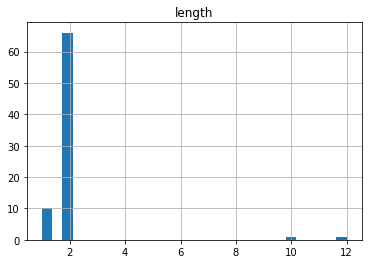

In [266]:
df_train.hist("length", bins=30);

In [267]:
lines_valid = Path("valid").read_text("utf-8").strip().splitlines()
lines_test = Path("test").read_text("utf-8").strip().splitlines()

df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])

kahalgaon:B-location_name river:B-river <=> ShowNearbyRiver
yogashala:B-yoga <=> ShowYogaPlaces
jagran:B-spritual_night_activity <=> ShowSpritualNightActivity
kahalgaon:B-location_name expressway:B-expressway <=> ShowNearbyExpressway
kahalgaon:B-location_name aghori:B-aghori <=> ShowAghori
kahalgaon:B-location_name ashram:B-ashram <=> ShowNearbyAshram
expressway:B-expressway <=> ShowNearbyExpressway
aghori:B-aghori <=> ShowAghori
ashram:B-ashram <=> ShowNearbyAshram
aarti:B-aarati <=> ShowGangaAarti
qawali:B-qawali <=> ShowQawali
varanasi:B-location_name population:B-population <=> ShowPlacePopulation
varanasi:B-location_name police:B-police <=> ShowPlacePoliceDetails
varanasi:B-location_name pincode:B-pincode <=> ShowPlacePincode
varanasi:B-location_name temple:B-temple <=> ShowPlaceTemples
varanasi:B-location_name yatra:B-yatra <=> ShowPlaceTourism
kahalgaon:B-location_name aarti:B-aarati <=> ShowGangaAarti
kahalgaon:B-location_name qawali:B-qawali <=> ShowQawali
kahalgaon:B-location


## A First Model: Intent Classification (Sentence Level)

Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the `huggingface/transformers` package that provides both TF2/Keras and Pytorch APIs.

### The BERT Tokenizer

First let's load a pre-trained tokenizer and test it on a test sentence from the training set:

In [268]:
from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [269]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'varanasi roadways'

In [270]:
tokenizer.tokenize(first_sentence)

['var', '##ana', '##si', 'roadway', '##s']

Notice that BERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.

**Question**:

- why is it particulary interesting to use subword tokenization for general purpose language models such as BERT?


Each token string is mapped to a unique integer id that makes it fast to lookup the right column in the input layer token embedding:

In [271]:
tokenizer.encode(first_sentence)

[101, 15661, 3906, 5053, 20722, 1116, 102]

In [272]:
tokenizer.decode(tokenizer.encode(first_sentence))

'[CLS] varanasi roadways [SEP]'

Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).
- Here we want to use BERT to compute a representation of a single voice command at a time
- We could reuse the representation of the `[CLS]` token for sequence classification.
- Alternatively we can pool the representations of all the tokens of the voice command (e.g. global average) and use that as the input of the final sequence classification layer.

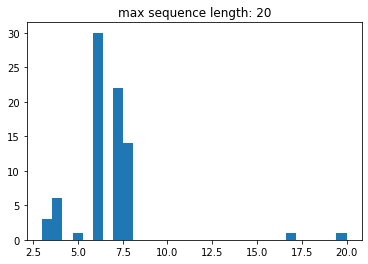

In [273]:
import matplotlib.pyplot as plt

train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

To perform transfer learning, we will need to work with padded sequences so they all have the same sizes. The above histograms, shows that after tokenization, 43 tokens are enough to represent all the voice commands in the training set.

The mapping can be introspected in the `tokenizer.vocab` attribute:

In [274]:
tokenizer.vocab_size

28996

In [275]:
bert_vocab_items = list(tokenizer.vocab.items())
bert_vocab_items[:10]

[('[PAD]', 0),
 ('[unused1]', 1),
 ('[unused2]', 2),
 ('[unused3]', 3),
 ('[unused4]', 4),
 ('[unused5]', 5),
 ('[unused6]', 6),
 ('[unused7]', 7),
 ('[unused8]', 8),
 ('[unused9]', 9)]

In [276]:
bert_vocab_items[100:110]

[('[UNK]', 100),
 ('[CLS]', 101),
 ('[SEP]', 102),
 ('[MASK]', 103),
 ('[unused100]', 104),
 ('[unused101]', 105),
 ('!', 106),
 ('"', 107),
 ('#', 108),
 ('$', 109)]

In [277]:
bert_vocab_items[900:910]

[('く', 900),
 ('け', 901),
 ('こ', 902),
 ('さ', 903),
 ('し', 904),
 ('す', 905),
 ('せ', 906),
 ('そ', 907),
 ('た', 908),
 ('ち', 909)]

In [278]:
bert_vocab_items[1100:1110]

[('－', 1100),
 ('／', 1101),
 ('：', 1102),
 ('the', 1103),
 ('of', 1104),
 ('and', 1105),
 ('to', 1106),
 ('in', 1107),
 ('was', 1108),
 ('The', 1109)]

In [279]:
bert_vocab_items[20000:20010]

[('attested', 20000),
 ('Hillary', 20001),
 ('##DM', 20002),
 ('gal', 20003),
 ('wander', 20004),
 ('Salle', 20005),
 ('##laming', 20006),
 ('Perez', 20007),
 ('Pit', 20008),
 ('##LP', 20009)]

In [280]:
bert_vocab_items[-10:]

[('##한', 28986),
 ('##ﬁ', 28987),
 ('##ﬂ', 28988),
 ('##！', 28989),
 ('##（', 28990),
 ('##）', 28991),
 ('##，', 28992),
 ('##－', 28993),
 ('##／', 28994),
 ('##：', 28995)]

Couple of remarks:

- 30K is a reasonable vocabulary size and is small enough to be used in a softmax output layer;
- it can represent multi-lingual sentences, including non-Western alphabets;
- subword tokenization makes it possible to deal with typos and morphological variations with a small vocabulary size and without any language-specific preprocessing;
- subword tokenization makes it unlikely to use the `[UNK]` special token as rare words can often be represented as a sequence of frequent enough short subwords in a meaningful way.

### Encoding the Dataset with the Tokenizer

Let's now encode the full train / valid and test sets with our tokenizer to get a padded integer numpy arrays:

In [281]:
import numpy as np


def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}


encoded_train = encode_dataset(tokenizer, df_train["words"], 45)
encoded_train["input_ids"]

array([[  101, 15661,  3906, ...,     0,     0,     0],
       [  101, 15661,  3906, ...,     0,     0,     0],
       [  101, 15661,  3906, ...,     0,     0,     0],
       ...,
       [  101,   182,  7563, ...,     0,     0,     0],
       [  101,  1437,  1143, ...,     0,     0,     0],
       [  101,  1437,  1143, ...,     0,     0,     0]], dtype=int32)

In [282]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [283]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 45)
encoded_test = encode_dataset(tokenizer, df_test["words"], 45)

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [284]:
intent_names = Path("vocab.intent").read_text("utf-8").split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'SearchImages': 0,
 'SearchNews': 1,
 'SearchPeople': 2,
 'SearchPolitics': 3,
 'SearchPortrait': 4,
 'SearchVideo': 5,
 'ShowAghori': 6,
 'ShowDistrictMagistrate': 7,
 'ShowGangaAarti': 8,
 'ShowImages': 9,
 'ShowImagesFromLocation': 10,
 'ShowIncredibleAboutPlace': 11,
 'ShowMlaPage': 12,
 'ShowMlaPageFromLocation': 13,
 'ShowMpPage': 14,
 'ShowMpPageFromLocation': 15,
 'ShowMukhiyaPage': 16,
 'ShowMukhiyaPageFromLocation': 17,
 'ShowNearbyAirport': 18,
 'ShowNearbyAshram': 19,
 'ShowNearbyExpressway': 20,
 'ShowNearbyMla': 21,
 'ShowNearbyMlaPage': 22,
 'ShowNearbyMp': 23,
 'ShowNearbyMpPage': 24,
 'ShowNearbyMukhiya': 25,
 'ShowNearbyMukhiyaPage': 26,
 'ShowNearbyPartyMembers': 27,
 'ShowNearbyProjects': 28,
 'ShowNearbyRiver': 29,
 'ShowNearbyWardBembers': 30,
 'ShowNews': 31,
 'ShowPartyHomePage': 32,
 'ShowPartyMembers': 33,
 'ShowPartyMembersFromLocation': 34,
 'ShowPartyPageFromLocation': 35,
 'ShowPlaceFood': 36,
 'ShowPlaceFoodReviewer': 37,
 'ShowPlaceHistory': 38,
 'ShowP

In [285]:
all_intent = set(intent_map.keys())

In [286]:
train_intenstset = set(list(df_train["intent_label"].unique() ) )
test_intenstset = set(list(df_test["intent_label"].unique() ) )
valid_intenstset = set(list(df_valid["intent_label"].unique() ) )

In [287]:
print( train_intenstset.difference(all_intent) )
print( test_intenstset.difference(all_intent) )
print( valid_intenstset.difference(all_intent) )

set()
set()
set()


In [288]:
intent_train = df_train["intent_label"].map(intent_map).values
intent_train

array([43, 38, 42, 37, 36, 11, 45, 46, 46, 49, 21, 28, 20,  6, 19,  8, 47,
       48,  7, 28, 18, 29, 43, 38, 42, 37, 36, 11, 45, 41, 40, 39, 44, 45,
       46, 55, 49, 21, 28, 20,  6, 19,  8, 47, 48,  7, 28, 18, 37, 36, 11,
       45, 41, 40, 39, 44, 45, 46, 55, 49, 21, 28,  7, 28, 18, 28, 48,  7,
       28, 18, 29, 30, 21, 21, 23, 25, 31, 31])

In [289]:
intent_valid = df_valid["intent_label"].map(intent_map).values
intent_test = df_test["intent_label"].map(intent_map).values

### Loading and Feeding a Pretrained BERT model

Let's load a pretrained BERT model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [290]:
from transformers import TFBertModel

base_bert_model = TFBertModel.from_pretrained("bert-base-cased")
base_bert_model.summary()

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [291]:
encoded_valid

{'input_ids': array([[  101, 24181,  7654, 27366,  2186,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 20631,  5480,  1742,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,   179,  8517,  4047,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0

In [292]:
outputs = base_bert_model(encoded_valid)
len(outputs)

2

The **first ouput** of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**:

In [293]:
outputs[0].shape

TensorShape([11, 45, 768])

The **second output** of the BERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**. This is will be used as the features of our Intent classifier:

In [294]:
outputs[1].shape

TensorShape([11, 768])

### Exercise

Use the following code template to build and train a **sequence classification model** using to predict the **intent class**.

Use the `self.bert` pre-trained model in the `call` method and only consider the pooled features (ignore the token-wise features for now).

In [295]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="bert-base-cased",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        # Let's preload the pretrained model BERT in the constructor of our
        # classifier model
        self.bert = TFBertModel.from_pretrained(model_name)

        # TODO: define a (Dense) classification layer to compute the 
        # for each sequence in a batch the batch of samples. The number of
        # output classes is given by the intent_num_labels parameter.

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.

    def call(self, inputs, **kwargs):
        # Use the pretrained model to extract features from our encoded inputs:
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        
        # TODO: use the classifier layer to compute the logits from the pooled
        # features.
        intent_logits = None
        return intent_logits


intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

# TODO: uncomment to train the model:

# history = intent_model.fit(encoded_train, intent_train, epochs=2, batch_size=32,
#                            validation_data=(encoded_valid, intent_valid))

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


### Solution

In [296]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense


class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="bert-base-cased",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.
        self.intent_classifier = Dense(intent_num_labels)

    def call(self, inputs, **kwargs):
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        pooled_output = self.dropout(pooled_output,
                                     training=kwargs.get("training", False))
        
        intent_logits = self.intent_classifier(pooled_output)
        return intent_logits


intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Our classification model outputs logits instead of probabilities. The final softmax normalization layer is implicit, that is, included in the loss function instead of the model directly.

We need to configure the loss function `SparseCategoricalCrossentropy(from_logits=True)` accordingly:

In [297]:
intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

In [298]:
history = intent_model.fit(encoded_train, intent_train, epochs=2, batch_size=32,
                           validation_data=(encoded_valid, intent_valid))

Epoch 1/2
3/3 [==============================] - 9s 3s/step - loss: 4.3866 - accuracy: 0.0641 - val_loss: 4.0690 - val_accuracy: 0.0000e+00
Epoch 2/2
3/3 [==============================] - 6s 2s/step - loss: 4.1470 - accuracy: 0.0641 - val_loss: 4.0715 - val_accuracy: 0.0000e+00


In [306]:
def classify(text, tokenizer, model, intent_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    class_id = model(inputs).numpy().argmax(axis=1)[0]
    return intent_names[class_id]


classify("varanasi food",
         tokenizer, intent_model, intent_names)

'ShowNearbyMla'

In [307]:
classify("delhi street food",
         tokenizer, intent_model, intent_names)

'ShowNearbyMla'

In [308]:
classify("kahalgaon mukhiya",
         tokenizer, intent_model, intent_names)

'ShowNearbyMla'

In [309]:
classify("ganga aarti varanasi",
         tokenizer, intent_model, intent_names)

'ShowNearbyMla'

## Join Intent Classification and Slot Filling

Let's now refine our Natural Language Understanding system by trying the retrieve the important structured elements of each voice command.

To do so we will perform word level (or token level) classification of the BIO labels.

Since we have word level tags but BERT uses a wordpiece tokenizer, we need to align the BIO labels with the BERT tokens.

Let's load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens:

In [324]:
slot_names = ["[PAD]"]
slot_names += Path("vocab.slot").read_text("utf-8").strip().splitlines()
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'B-god': 1,
 'B-church': 2,
 'B-gurudwara': 3,
 'B-city': 4,
 'B-condition_description': 5,
 'B-condition_temperature': 6,
 'B-country': 7,
 'B-cuisine': 8,
 'B-current_location': 9,
 'B-entity_name': 10,
 'B-location_name': 11,
 'B-object_location_type': 12,
 'B-object_name': 13,
 'B-object_part_of_series_type': 14,
 'B-object_select': 15,
 'B-object_type': 16,
 'B-party_size_description': 17,
 'B-party_size_number': 18,
 'B-state': 19,
 'B-timeRange': 20,
 'B-people': 21,
 'B-year': 22,
 'B-pincode': 23,
 'B-temple': 24,
 'B-airport': 25,
 'B-news': 26,
 'B-live': 27,
 'B-history': 28,
 'B-ghat': 29,
 'B-tourism': 30,
 'B-population': 31,
 'B-river': 32,
 'B-mla': 33,
 'B-mp': 34,
 'B-mukhiya': 35,
 'B-ward_member': 36,
 'B-Incredible': 37,
 'B-rajyasabha_member': 38,
 'B-political_party': 39,
 'B-university': 40,
 'B-college': 41,
 'B-school': 42,
 'B-mosque': 43,
 'B-police': 44,
 'B-international': 45,
 'B-bullet_train': 46,
 'B-yoga': 47,
 'B-yatra': 48,
 'B-gold': 

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [325]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,
                        max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded


slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 45)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 45)
slot_test = encode_token_labels(
    df_test["words"], df_test["word_labels"], tokenizer, slot_map, 45)

In [326]:
slot_train[0]

array([ 0, 11, 89, 89, 62, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [327]:
slot_valid[0]

array([ 0, 11, 89, 89, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

### Exercise

Use the following code template to build a joint sequence and token classification model suitable for training on our encoded dataset with slot labels:



In [328]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense


class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        # TODO: define all the needed layers here.

    def call(self, inputs, **kwargs):
        # TODO: extrac the features from the inputs using the pre-trained
        # BERT model here.

        # TODO: use the new layers to predict slot class (logits) for each
        # token position in the input sequence:
        slot_logits = None  # (batch_size, seq_len, slot_num_labels)

        # TODO: define a second classification head for the sequence-wise
        # predictions:
        intent_logits = None  # (batch_size, intent_num_labels)

        return slot_logits, intent_logits


joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

# Define one classification loss for each output:
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
joint_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                    loss=losses)

# TODO: uncomment to train the model:
# history = joint_model.fit(
#     encoded_train, (slot_train, intent_train),
#     validation_data=(encoded_valid, (slot_valid, intent_valid)),
#     epochs=2, batch_size=32)

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.









### Solution:


In [329]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense


class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, **kwargs):
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        # The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output,
                                       training=kwargs.get("training", False))
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output,
                                     training=kwargs.get("training", False))
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits


joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [330]:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [331]:
history = joint_model.fit(
    encoded_train, (slot_train, intent_train),
    validation_data=(encoded_valid, (slot_valid, intent_valid)),
    epochs=2, batch_size=32)

Epoch 1/2
3/3 [==============================] - 8s 3s/step - loss: 7.2252 - output_1_loss: 2.6821 - output_2_loss: 4.5431 - output_1_accuracy: 0.5305 - output_2_accuracy: 0.0256 - val_loss: 4.8679 - val_output_1_loss: 0.4837 - val_output_2_loss: 4.3841 - val_output_1_accuracy: 0.9253 - val_output_2_accuracy: 0.0000e+00
Epoch 2/2
3/3 [==============================] - 6s 2s/step - loss: 5.0313 - output_1_loss: 0.6849 - output_2_loss: 4.3464 - output_1_accuracy: 0.8960 - output_2_accuracy: 0.0256 - val_loss: 4.4270 - val_output_1_loss: 0.4138 - val_output_2_loss: 4.0132 - val_output_1_accuracy: 0.9253 - val_output_2_accuracy: 0.0000e+00


The following function uses our trained model to make a prediction on a single text sequence and display both the sequence-wise and the token-wise class labels:

In [332]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

In [333]:
show_predictions("varanasi ghat",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: ShowPartyHomePage
## Slots:
       var : B-year
     ##ana : I-mosque
      ##si : I-god
         g : [PAD]
     ##hat : [PAD]


In [335]:
show_predictions("delhi mlas",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: ShowPartyHomePage
## Slots:
       del : [PAD]
      ##hi : [PAD]
         m : [PAD]
     ##las : [PAD]


In [336]:
show_predictions("I would like to listen to Anima by Thom Yorke.",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: ShowPlacePopulation
## Slots:
         I : B-political_party
     would : I-temple
      like : I-live
        to : [PAD]
    listen : [PAD]
        to : [PAD]
        An : [PAD]
     ##ima : [PAD]
        by : [PAD]
      Thom : [PAD]
      York : B-condition_temperature
       ##e : [PAD]
         . : [PAD]


### Decoding Predictions into Structured Knowledge

For completeness, here a minimal function to naively decode the predicted BIO slot ids and convert it into a structured representation for the detected slots as a Python dictionaries: 

In [337]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

In [338]:
def nlu(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

nlu("Book a table for two at Le Ritz for Friday night",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'ShowPlacePopulation',
 'slots': {'aarati': 'for',
  'AD]': 'for Friday night',
  'geographic_poi': 'table',
  'party': 'Ritz'}}

In [339]:
nlu("Will it snow tomorrow in Saclay",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'ShowPartyHomePage',
 'slots': {'AD]': 'snow tomorrow in Saclay', 'city': 'it'}}

In [340]:
nlu("I would like to listen to Anima by Thom Yorke",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'ShowPlacePopulation',
 'slots': {'AD]': 'by Thom',
  'temple': 'would',
  'river': 'like',
  'city': 'to',
  'people': 'Anima',
  'Actress': 'Yorke'}}

## Limitations

### Language

BERT is pretrained primarily on English content. It can therefore only extract meaningful features on text written in English.

Note that there exists alternative pretrained model that use a mix of different languages (e.g. [XLM](https://github.com/facebookresearch/XLM/)) and others that have been trained on other languages. For instance [CamemBERT](https://camembert-model.fr/) is pretrained on French text. Both kinds of models are available in the transformers package:

https://github.com/huggingface/transformers#model-architectures

The public snips.ai dataset used for fine-tuning is English only. To build a model for another language we would need to collect and annotate a similar corpus with tens of thousands of diverse, representative samples.


### Biases Embedded in the Pre-Trained Model

The original data used to pre-trained BERT was collected from the Internet and contains all kinds of data, including offensive and hateful speech.

While using BERT for or voice command understanding system is quite unlikely to be significantly impacted by those biases, it could be a serious problem for other kinds of applications such as Machine Translation for instance.

It is therefore strongly recommended to spend time auditing the biases that are embedded in such pre-trained models before deciding to deploy system that derive from them.

### Computational Resources

The original BERT model has many parameters which uses a lot of memory and can be prohibitive to deploy on small devices such as mobile phones. It is also very computationally intensive and typically requires powerful GPUs or TPUs to process text data at a reasonable speed (both for training and at inference time).

Designing alternative architectures with fewer parameters or more efficient training and inference procedures is still a very active area of research.

Depending of on the problems, it might be the case that simpler architectures based on convolutional neural networks and LSTMs might offer a better speed / accuracy trade-off.


In [343]:
nlu("show me news about srk from kolkata from ndtv publisher",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'ShowPlacePopulation',
 'slots': {'city': 'show',
  'AD]': 'me news about srk from kolkata from ndtv publisher'}}

In [345]:
nlu("show me mlas",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'ShowPartyHomePage', 'slots': {'AD]': 'show me mlas'}}

In [346]:
nlu("delhi temples",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'ShowPartyHomePage',
 'slots': {'country': 'delhi', 'AD]': 'temples'}}